# Bitcoin Price Prediction with Deep Learning
#### By Jason Wei and William Wolfe-McGuire
Use open, high, low, close, volume, market cap values for Bitcoin to predict the closing price of the next day. 

In [1]:
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.layers import Bidirectional
from keras.models import Sequential
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Using TensorFlow backend.


## 1. Data Preprocessing

We want to transform our data from a n by 6, where there are n days and 6 features (open, high, low, close, volume, market cap) into a n by 49 by 6 tensor where we have prices for days 1 to 49, 2 to 50, ... n-48 to n, to predict the closing price for the next day.

In [2]:
def load_data(filename, seq_len):

    df = pd.read_csv(filename, dtype=float, header=None).values
    df[df == 0] = 1
    data = df.tolist()
    
    result = []
    for index in range(len(data) - seq_len):
        result.append(data[index: index + seq_len])
    
    #normalize data
    d0 = np.array(result)
    dr = np.zeros_like(d0)
    dr[:,1:,:] = d0[:,1:,:] / d0[:,0:1,:] - 1
    result = dr[:, :, :6] #only want six columns since our dataset has extraneous information
    
    #to unnormalize it later
    start = int(dr.shape[0]*0.9)
    end = int(dr.shape[0]+1)
    unnormalize_bases = d0[start:end,0:1,0]

    #split into train and testing data
    row = round(0.9 * result.shape[0])
    train = result[:int(row), :]
    np.random.shuffle(train)
    x_train = train[:, :-1]
    y_train = train[:, -1]
    y_train = y_train[:,3]
   
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, 49, :]
    y_test = y_test[:,3]
    
    #the day before y_test aka today's price
    y_dayb4 = result[int(row):, 48, :]
    y_dayb4 = y_dayb4[:,3]
    
    return [x_train, y_train, x_test, y_test, unnormalize_bases, y_dayb4]

Load the data from the csv and preprocess it. Our csv has data for a lot of cryptocurrencies but only the first six are related to bitcoin.

In [3]:
sequence_length = 50
lookback = sequence_length - 1
X_train, y_train, X_test, y_test, unnormalize_bases, y_dayb4 = load_data('crypto.csv', sequence_length)
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)

X_train: (855, 49, 6)
y_train: (855,)
X_test: (95, 49, 6)
y_test: (95,)


# 2. Build and Train our Neural Net.

Build neural net with 3 layers of bidirectional LSTM cells. 

In [4]:
model = Sequential()

model.add(Bidirectional(LSTM(lookback,return_sequences=True), input_shape=(lookback,X_train.shape[-1]),))
model.add(Dropout(0.2))

model.add(Bidirectional(LSTM((lookback*2), return_sequences=True)))
model.add(Dropout(0.2))

model.add(Bidirectional(LSTM(lookback, return_sequences=False)))

model.add(Dense(output_dim=1))
model.add(Activation('tanh'))

model.compile(loss='mse', optimizer='adam')
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 49, 98)            21952     
_________________________________________________________________
dropout_1 (Dropout)          (None, 49, 98)            0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 49, 196)           154448    
_________________________________________________________________
dropout_2 (Dropout)          (None, 49, 196)           0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 98)                96432     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 99        
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total para

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`
  # This is added back by InteractiveShellApp.init_path()


Train the model. It can definitely be done on a cpu but it might take a while...

In [9]:
start = time.time()
model.fit(X_train, y_train, batch_size=1024, nb_epoch=10, validation_split=0.05)
print('training time : ', time.time() - start)

/anaconda/lib/python3.6/site-packages/keras/models.py:844: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 812 samples, validate on 43 samples
Epoch 1/10
812/812 [==============================] - 3s - loss: 0.0030 - val_loss: 0.0023
Epoch 2/10
812/812 [==============================] - 3s - loss: 0.0029 - val_loss: 0.0021
Epoch 3/10
812/812 [==============================] - 3s - loss: 0.0029 - val_loss: 0.0021
Epoch 4/10
812/812 [==============================] - 3s - loss: 0.0030 - val_loss: 0.0021
Epoch 5/10
812/812 [==============================] - 3s - loss: 0.0029 - val_loss: 0.0020
Epoch 6/10
812/812 [==============================] - 3s - loss: 0.0029 - val_loss: 0.0021
Epoch 7/10
812/812 [==============================] - 3s - loss: 0.0029 - val_loss: 0.0024
Epoch 8/10
812/812 [==============================] - 3s - loss: 0.0029 - val_loss: 0.0027
Epoch 9/10
812/812 [==============================] - 3s - loss: 0.0031 - val_loss: 0.0022
Epoch 10/10
812/812 [==============================] - 3s - loss: 0.0027 - val_loss: 0.0021
training time :  34.891350984573364


# 3. Results.
None of the ways of evaluating the model are perfect, but there are several ways that are helpful... first we can graph the plot of the price, but it can be misleading since we are only predicting the next day.

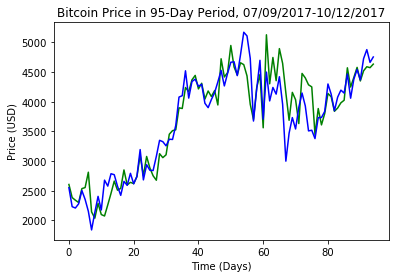

In [10]:
y_predict = model.predict(X_test)
real_y_test = np.zeros_like(y_test)
real_y_predict = np.zeros_like(y_predict)

for i in range(y_test.shape[0]):
    y = y_test[i]
    predict = y_predict[i]
    real_y_test[i] = (y+1)*unnormalize_bases[i]
    real_y_predict[i] = (predict+1)*unnormalize_bases[i]
    
plt.plot(real_y_predict, color='green')
plt.plot(real_y_test, color='blue')
plt.title("Bitcoin Price in 95-Day Period, 07/09/2017-10/12/2017")
plt.ylabel("Price (USD)")
plt.xlabel("Time (Days)")
plt.savefig('price.png', dpi = 600)
plt.show()

A plot of the predicted change:

y_predict: (95, 1)
y_dayb4: (95, 1)
y_test: (95, 1)


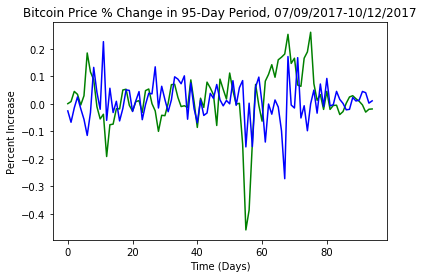

In [11]:
print("y_predict:", y_predict.shape)
y_dayb4 = np.reshape(y_dayb4, (-1, 1))
print("y_dayb4:", y_dayb4.shape)
y_test = np.reshape(y_test, (-1, 1))
print("y_test:", y_test.shape)
delta_predict = y_predict - y_dayb4
delta_real = y_test - y_dayb4
plt.plot(delta_predict, color='green')
plt.plot(delta_real, color='blue')
plt.title("Bitcoin Price % Change in 95-Day Period, 07/09/2017-10/12/2017")
plt.ylabel("Percent Increase")
plt.xlabel("Time (Days)")
plt.savefig('best_fluctuation.png', dpi = 600)
plt.show()

Precision, Recall, F1, MSE:

In [13]:
#one means predict stock increases in price, zero means decrease
delta_predict_1_0 = np.empty(delta_predict.shape)
delta_real_1_0 = np.empty(delta_real.shape)

for i in range(delta_predict.shape[0]):
    if delta_predict[i][0] > 0:
        delta_predict_1_0[i][0] = 1
    else:
        delta_predict_1_0[i][0] = 0

for i in range(delta_real.shape[0]):
    if delta_real[i][0] > 0:
        delta_real_1_0[i][0] = 1
    else:
        delta_real_1_0[i][0] = 0    

true_pos = 0
false_pos = 0
true_neg = 0
false_neg = 0

for i in range(delta_real_1_0.shape[0]):
    real = delta_real_1_0[i][0]
    predicted = delta_predict_1_0[i][0]
    if real == 1:
        if predicted == 1:
            true_pos += 1
        else:
            false_pos += 1
    elif real == 0:
        if predicted == 0:
            true_neg += 1
        else:
            false_neg += 1

print("true_pos:", true_pos)
print("true_neg:", true_neg)
print("false_pos:", false_pos)
print("false_neg:", false_neg)

precision = float(true_pos) / (true_pos + false_pos)
recall = float(true_pos) / (true_pos + false_neg)
F1 = 2.0 / (1/precision + 1/recall)

print()
print("precision:", precision)
print("recall:", recall)
print("F1:", F1)

#MSE
from sklearn.metrics import mean_squared_error
print()
print("Testing MSE:", mean_squared_error(y_predict.flatten(), y_test.flatten()))

true_pos: 28
true_neg: 17
false_pos: 22
false_neg: 28

precision: 0.56
recall: 0.5
F1: 0.5283018867924528

Testing MSE: 0.0147935232114
